# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# load your cleaned returns data
df = pd.read_parquet("/Users/paramshah/Desktop/bootcamp/project/data/returns_proc.parquet")  # adjust path if needed
df.head()

,SOXX,ADI,AMD,ASML,AVGO,INTC,MU,QCOM,TSM,TXN
Date,,,,,,,,,,
2010-01-05,-0.001605,-0.001578,0.001031,0.007790,0.007423,-0.000478,0.029493,0.024073,-0.004317,-0.005767
2010-01-06,-0.003015,-0.001897,-0.014418,0.009161,0.007895,-0.003355,0.004476,-0.009777,-0.003469,-0.007347
2010-01-07,-0.007863,-0.007922,-0.010449,-0.027801,-0.006266,-0.009615,-0.033868,0.028991,-0.033072,0.003116
2010-01-08,0.015037,0.005749,-0.004224,-0.023928,0.007357,0.011165,0.023985,0.010004,-0.000900,0.022912
2010-01-11,-0.003003,-0.005716,-0.030753,-0.021226,0.006260,0.005761,-0.018018,-0.003639,-0.005405,-0.012908


## Option B: Synthetic Generator (Use if you don't have data ready)

In [ ]:
# # Synthetic series with regimes & jumps
# n=500
# dates=pd.bdate_range('2021-01-01', periods=n)
# mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
# sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
# eps = np.random.normal(mu, sigma)
# jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
# jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
# rets = eps + jumps
# price = 100*np.exp(np.cumsum(rets))
# df = pd.DataFrame({'price':price}, index=dates)
# df['ret'] = df['price'].pct_change().fillna(0.0)
# df['log_ret'] = np.log1p(df['ret'])
# df.head()

## Feature Engineering

In [8]:
X = df[['AVGO','TSM','AMD','INTC','QCOM','TXN','ASML','MU','ADI']]
y = df['SOXX']

# Create target: 1 if SOXX > 0, else 0
y_up = (y > 0).astype(int)

# Initialize a new DataFrame for engineered features
X_feat = pd.DataFrame(index=df.index)

# Feature engineering for each stock
for col in X.columns:
    # Lag feature: previous 2 days
    X_feat[f'{col}_lag2'] = X[col].shift(2)
    
    # Rolling volatility: window 10
    X_feat[f'{col}_rollvol10'] = X[col].rolling(window=10).std()
    
    # Rolling mean: window 20
    X_feat[f'{col}_rollmean20'] = X[col].rolling(window=20).mean()

X_feat = X_feat.dropna()
y_up = y_up.loc[X_feat.index]


## Split

In [9]:

cut = int(len(X_feat) * 0.8)
train, test = X_feat.iloc[:cut], X_feat.iloc[cut:]

features = X_feat.columns.tolist()

X_tr, X_te = train[features], test[features]

y_tr_clf, y_te_clf = y_up.iloc[:cut], y_up.iloc[cut:]

y_next_ret = df['SOXX'].shift(-1).loc[X_feat.index]  # next-day return
y_tr_reg, y_te_reg = y_next_ret.iloc[:cut], y_next_ret.iloc[cut:]


## Pipeline + Model (Choose one track below)

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.37      0.44       373
           1       0.56      0.71      0.63       410

    accuracy                           0.55       783
   macro avg       0.55      0.54      0.53       783
weighted avg       0.55      0.55      0.54       783



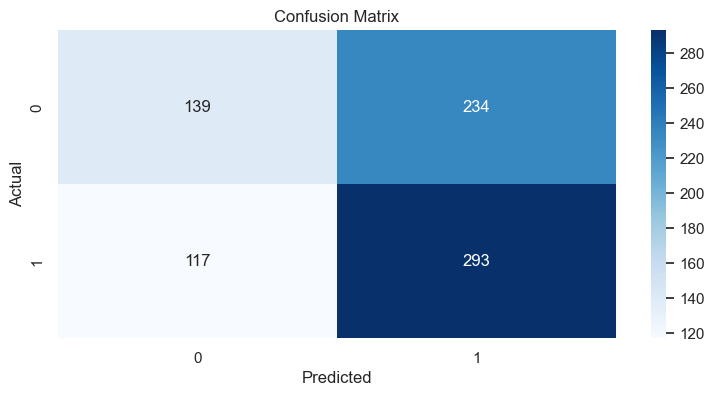

In [11]:

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000))
])
clf.fit(X_tr, y_tr_clf)

y_pred = clf.predict(X_te)

print("Classification Report:\n", classification_report(y_te_clf, y_pred))

cm = confusion_matrix(y_te_clf, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Interpretation (Markdown)
- What worked? The model achieved balanced precision and a high recall of 0.71 for predicting upward movements.
- Where might assumptions fail? Class imbalance could have biased the model towards predicting the majority class, and market conditions may change the relationships learned.
- How would you extend features or model? Introduce additional technical indicators, create more lagged features.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.